## ASTER data pipeline analysis

In [1]:
import os
import sys
import cioppy

import geopandas as gpd
import pandas as pd
import tempfile
import getpass

import numpy as np
import pandas as pd

from shapely.wkt import loads
from shapely.geometry import box
from shapely.geometry import Point

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
sys.path.append(os.getcwd())
sys.path.append('/opt/OTB/lib/python')
sys.path.append('/opt/OTB/lib/libfftw3.so.3')
os.environ['OTB_APPLICATION_PATH'] = '/opt/OTB/lib/otb/applications'
os.environ['LD_LIBRARY_PATH'] = '/opt/OTB/lib'
os.environ['ITK_AUTOLOAD_PATH'] = '/opt/OTB/lib/otb/applications'
import otbApplication
import gdal

from aster_helpers import retrieve_pixel_value_signature, get_vsi_url, analyse_row, get_image_as_mem, create_mem_composite

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Authentication information

Set the credentials to access the data pipeline results, and then click on the next Cell:

In [2]:
user = raw_input("Enter you Terradue username:")
api_key = getpass.getpass("Enter the API key:")

#### Define the point of interest

The point of interest (Jones Lake) is passed as a longitude and latitude:

In [3]:
point_lat = 34.693
point_lon = -78.600
 
aoi = Point(point_lon, point_lat)

#### Query the datapipeline for results

Search for data pipeline items produced on the 5th and 6th of June over Jones Lake

In [4]:
out_url = 'https://catalog.terradue.com/{0}/description'.format('ifpen-00001')

In [5]:
creds = '{0}:{1}'.format(user, api_key)

In [6]:
ciop = cioppy.Cioppy()

search_params = dict()

search_params['cat'] = '{out}'
search_params['geom'] = aoi.wkt
search_params['count'] = '150'
search_params['update'] = '2019-06-05T00:00:00Z/2019-06-10T23:59:59Z'

search = gpd.GeoDataFrame(ciop.search(end_point=out_url,
                                      params=search_params,
                                      output_fields='link:results',
                                      model='EOP',
                                      creds=creds))


In [7]:
len(search)

36

In [8]:
search.head(5)

link:results
0  https://catalog.terradue.com/ifpen-00001/cat/0...
1  https://catalog.terradue.com/ifpen-00001/cat/3...
2  https://catalog.terradue.com/ifpen-00001/cat/c...
3  https://catalog.terradue.com/ifpen-00001/cat/e...
4  https://catalog.terradue.com/ifpen-00001/cat/0...

For each results URL, get the associated results metadata:

In [9]:
fields = 'title,identifier,self,enclosure,cat,cc,wkt,updated,startdate'
search_params = []

df = pd.DataFrame()

for index, row in search.iterrows():
    
    end_point = row['link:results']

    temp_df = pd.DataFrame.from_dict(ciop.search(end_point=end_point,
                                                 params=search_params,
                                                 output_fields=fields, 
                                                 model='EOP', 
                                                 creds=creds))

    df = df.append(temp_df, ignore_index=True)


Sort the results by date and reset the index 

In [10]:
search = df.sort_values(by=['startdate'])

search = search.reset_index(drop=True)

In [11]:
search.head(5)    

cat   cc  \
0  VNIR1;VNIR2;SWIR;TIR;Band1;Band2;Band3N;Band4;...   34   
1  VNIR1;VNIR2;SWIR;TIR;Band1;Band2;Band3N;Band4;...   23   
2  VNIR1;VNIR2;SWIR;TIR;Band1;Band2;Band3N;Band4;...   18   
3  VNIR1;VNIR2;SWIR;TIR;Band1;Band2;Band3N;Band4;...  100   
4  VNIR1;VNIR2;SWIR;TIR;Band1;Band2;Band3N;Band4;...    5   

                                           enclosure  \
0  https://store.terradue.com/ifpen-00001/_result...   
1  https://store.terradue.com/ifpen-00001/_result...   
2  https://store.terradue.com/ifpen-00001/_result...   
3  https://store.terradue.com/ifpen-00001/_result...   
4  https://store.terradue.com/ifpen-00001/_result...   

                                 identifier  \
0  5C7D28A45959BDB3A5830B354A59EC542EF0CE2B   
1  CC83643B91E6DD3F39FE41D57438ADFA2D897BA6   
2  6ABA6AF50D3D25D9EEC0B770C8CE509D6D55916B   
3  AB3670A03D9ECC51D96A7F243E24277C03ECAC16   
4  DF5AD88BA715DF8F75460A02CFC06967228DA487   

                                                self  \
0  https://catalog.terradue.com//ifpen-00001/cat/...   
1  https://catalog.terradue.com//ifpen-00001/cat/...   
2  https://catalog.terradue.com//ifpen-00001/cat/...   
3  https://catalog.terradue.com//ifpen-00001/cat/...   
4  https://catalog.terradue.com//ifpen-00001/cat/...   

                      startdate  \
0  2002-05-17T16:06:41.0000000Z   
1  2002-07-20T16:06:46.0000000Z   
2  2002-08-05T16:06:32.0000000Z   
3  2002-08-28T16:12:44.0000000Z   
4  2002-09-29T16:12:31.0000000Z   

                                               title  \
0  AST_L2p_00305172002160641_20150422132909_90836...   
1  AST_L2p_00307202002160646_20150423091546_10409...   
2  AST_L2p_00308052002160632_20150424003726_71166...   
3  AST_L2p_00308282002161244_20150424162851_67874...   
4  AST_L2p_00309292002161231_20150425104726_16740...   

                             updated  \
0  2019-06-05T09:48:52.5374890+00:00   
1  2019-06-05T10:20:44.8248600+00:00   
2  2019-06-05T10:19:40.4596000+00:00   
3  2019-06-05T10:18:39.0295330+00:00   
4  2019-06-05T10:34:27.4738080+00:00   

                                                 wkt  
0  POLYGON((-78.6088743158048 34.358809165236,-77...  
1  POLYGON((-78.6432649233889 34.3637722789264,-7...  
2  POLYGON((-78.5892518077508 34.355042874362,-77...  
3  POLYGON((-79.4022512891906 34.2441308262138,-7...  
4  POLYGON((-79.3865382895526 34.2413988558444,-7...

#### Retrieve the spectral signatures over the defined point of interest

In [12]:
signatures = pd.DataFrame()

for index_row, row in search.iterrows():

    signature = pd.DataFrame.from_dict([analyse_row(row, aoi, user, api_key)])

    signatures = signatures.append(signature, ignore_index=True)


In [13]:
signatures.head(5)

BT_10       BT_11      BT_12       BT_13       BT_14  CLOUD_MASK_1  \
0    0.000000    0.000000    0.00000    0.000000    0.000000           0.0   
1    0.000000    0.000000    0.00000    0.000000    0.000000           0.0   
2         NaN         NaN        NaN         NaN         NaN           NaN   
3  242.030029  242.017273  241.14650  241.558563  241.275253           0.0   
4  289.389038  291.960114  293.59668  294.487976  293.591064           0.0   

   CLOUD_MASK_2  REFLECTANCE_1  REFLECTANCE_2  REFLECTANCE_3N  \
0           0.0       0.000000       0.000000        0.000000   
1           0.0       0.000000       0.000000        0.000000   
2           NaN            NaN            NaN             NaN   
3           0.0       0.340634       0.425623        0.720552   
4           0.0       0.072820       0.046423        0.179187   

                  ...                  REFLECTANCE_7  REFLECTANCE_8  \
0                 ...                       0.000000       0.000000   
1                 ...                       0.000000       0.000000   
2                 ...                            NaN            NaN   
3                 ...                       0.167111       0.105490   
4                 ...                       0.041088       0.022855   

   REFLECTANCE_9   cc                                          enclosure  \
0       0.000000   34  https://store.terradue.com/ifpen-00001/_result...   
1       0.000000   23  https://store.terradue.com/ifpen-00001/_result...   
2            NaN   18  https://store.terradue.com/ifpen-00001/_result...   
3       0.075730  100  https://store.terradue.com/ifpen-00001/_result...   
4       0.023855    5  https://store.terradue.com/ifpen-00001/_result...   

         epsg pixel_coord_x pixel_coord_y                     startdate  \
0  EPSG:32617           115          2564  2002-05-17T16:06:41.0000000Z   
1  EPSG:32617           325          2594  2002-07-20T16:06:46.0000000Z   
2  EPSG:32617            -4          2540  2002-08-05T16:06:32.0000000Z   
3  EPSG:32617          4927          1646  2002-08-28T16:12:44.0000000Z   
4  EPSG:32617          4831          1628  2002-09-29T16:12:31.0000000Z   

                                  wkt  
0  POINT(719841.602725 3841620.40367)  
1  POINT(719841.602725 3841620.40367)  
2  POINT(719841.602725 3841620.40367)  
3  POINT(719841.602725 3841620.40367)  
4  POINT(719841.602725 3841620.40367)  

[5 rows x 23 columns]

Select only the signature that have data:

In [14]:
signatures = signatures[(signatures['CLOUD_MASK_1'] == 0) &
                        (signatures['CLOUD_MASK_2'] == 0) & 
                        (signatures['REFLECTANCE_1'] != 0)] 

In [15]:
signatures = signatures.reset_index(drop=True)

In [16]:
signatures

BT_10       BT_11       BT_12       BT_13       BT_14  CLOUD_MASK_1  \
0   242.030029  242.017273  241.146500  241.558563  241.275253           0.0   
1   289.389038  291.960114  293.596680  294.487976  293.591064           0.0   
2   244.274887  244.061722  244.087372  244.017456  243.157333           0.0   
3   272.395844  273.187775  273.588776  275.008728  274.713776           0.0   
4   281.072510  281.746185  281.665466  283.537720  283.723999           0.0   
5   293.546204  296.135498  298.147308  298.950287  297.802155           0.0   
6   290.187012  292.498840  293.828979  294.709229  293.493805           0.0   
7   285.328979  287.500519  287.862640  289.336456  288.687683           0.0   
8   287.566559  289.683258  290.936035  291.533173  290.389771           0.0   
9   288.055450  289.912750  290.596893  292.290619  291.933411           0.0   
10  289.196472  291.753448  293.697266  294.434875  293.118591           0.0   
11  220.244263  220.441223  220.767059  219.681808  218.761261           0.0   
12  279.041504  279.824646  280.385681  282.223724  281.947357           0.0   
13  275.526367  276.043182  276.282471  277.599670  277.537231           0.0   
14  288.617096  290.384918  291.639191  292.992554  292.313690           0.0   
15  293.988281  296.085510  296.957184  298.585297  298.182587           0.0   

    CLOUD_MASK_2  REFLECTANCE_1  REFLECTANCE_2  REFLECTANCE_3N  \
0            0.0       0.340634       0.425623        0.720552   
1            0.0       0.072820       0.046423        0.179187   
2            0.0       0.407498       0.509170        0.665159   
3            0.0       0.072267       0.051599        0.161604   
4            0.0       0.068345       0.046581        0.167573   
5            0.0       0.086372       0.060706        0.236945   
6            0.0       0.083190       0.056378        0.187905   
7            0.0       0.079805       0.052680        0.203850   
8            0.0       0.152252       0.126279        0.266534   
9            0.0       0.070749       0.050783        0.178315   
10           0.0       0.119634       0.086632        0.304827   
11           0.0       0.362586       0.453052        0.766987   
12           0.0       0.075228       0.052528        0.205934   
13           0.0       0.069522       0.044675        0.172273   
14           0.0       0.081419       0.058626        0.189743   
15           0.0       0.083664       0.060436        0.199099   

                   ...                  REFLECTANCE_7  REFLECTANCE_8  \
0                  ...                       0.167111       0.105490   
1                  ...                       0.041088       0.022855   
2                  ...                       0.202585       0.141278   
3                  ...                       0.040610       0.026425   
4                  ...                       0.043253       0.029282   
5                  ...                       0.048701       0.031001   
6                  ...                       0.039511       0.024419   
7                  ...                       0.037044       0.026089   
8                  ...                       0.086634       0.061790   
9                  ...                       0.046935       0.033818   
10                 ...                       0.086271       0.057767   
11                 ...                       0.340196       0.252552   
12                 ...                       0.043054       0.033602   
13                 ...                       0.039002       0.031696   
14                 ...                       0.052473       0.036342   
15                 ...                       0.055583       0.037715   

    REFLECTANCE_9   cc                                          enclosure  \
0        0.075730  100  https://store.terradue.com/ifpen-00001/_result...   
1        0.023855    5  https://store.terradue.com/ifpen-00001/_result...   
2        0.107484  100  https://store.terradue.com/ifpen-00001/_resul

#### Extract data and create images

Select a row of the signatures dataframe

In [17]:
loc = 3

Plotting data for the date:

In [18]:
print signatures.iloc[loc]['startdate'] 

2003-01-19T16:12:16.0000000Z


Create a buffer around the point of interest:

In [19]:
buffer_size=2500

aoi_wkt = box(*loads(signatures.iloc[loc]['wkt']).buffer(buffer_size).bounds)

Request the data without download:

In [20]:
data = get_image_as_mem(signatures.iloc[loc]['enclosure'],
                        user, 
                        api_key,
                        list(aoi_wkt.bounds),
                        signatures.iloc[loc]['epsg'])

Size of data provided as: (cols, rows, bands)

In [21]:
print(data.shape)

(333, 333, 16)


##### NDVI

In [22]:
band_expressions = ['(im1b3 + im1b2) !=0 ? (im1b3 - im1b2) / (im1b3 + im1b2) : -1']

In [23]:
BandMathX = otbApplication.Registry.CreateApplication("BandMathX")

BandMathX.SetVectorImageFromNumpyArray('il', data)
BandMathX.SetParameterString('exp', ';'.join(band_expressions))
BandMathX.Execute()

ndvi = BandMathX.GetImageAsNumpyArray('out')

In [24]:
print(ndvi.shape)

(333, 333)


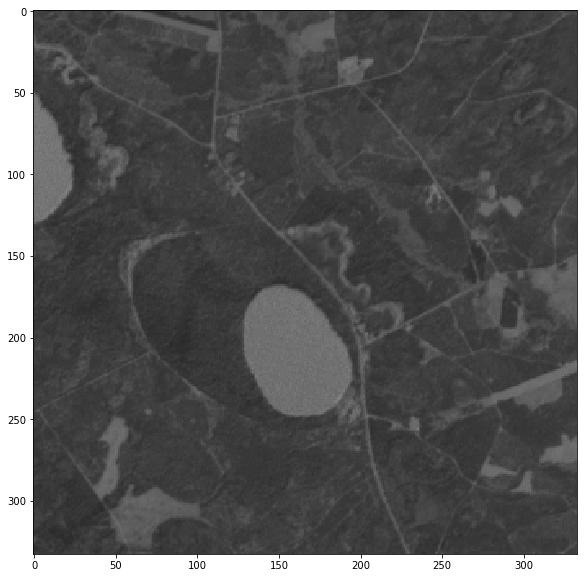

In [25]:
width = 10
height = 10
plt.figure(figsize=(width, height))

imgplot = plt.imshow(ndvi, cmap=plt.cm.binary, vmin=-1, vmax=1)


##### RGB composite with bands 3,2,1

In [26]:
band_expression = ['im1b3', 'im1b2', 'im1b1']


In [27]:
rgb = create_mem_composite(band_expression, data)

In [28]:
print(rgb.shape)

(333, 333, 3)


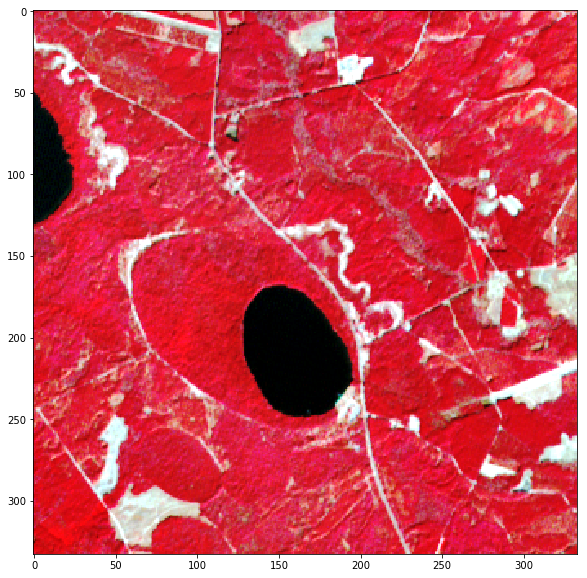

In [29]:
width = 10
height = 10
plt.figure(figsize=(width, height))
img = Image.fromarray(rgb)
imgplot = plt.imshow(img)

##### RGB composite with bands 8,9,7

In [30]:
band_expressions = ['im1b8', 'im1b9', 'im1b7']

In [31]:
rgb = create_mem_composite(band_expressions, data)

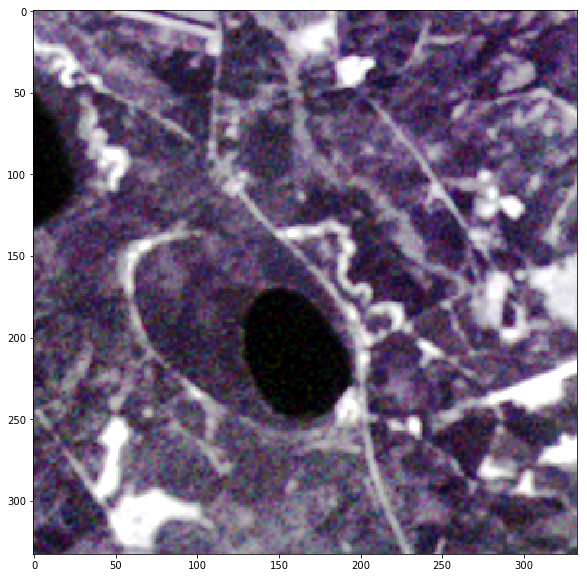

In [32]:
width = 10
height = 10
plt.figure(figsize=(width, height))
img = Image.fromarray(create_mem_composite(band_expressions, data))
imgplot = plt.imshow(img)

#### Plot the signature

Plot the signature for row 6:

In [33]:
sig = signatures.iloc[6][['REFLECTANCE_1', 
                      'REFLECTANCE_2', 
                      'REFLECTANCE_3N', 
                      'REFLECTANCE_4', 
                      'REFLECTANCE_5', 
                      'REFLECTANCE_6', 
                      'REFLECTANCE_7', 
                      'REFLECTANCE_8', 
                      'REFLECTANCE_9']].values

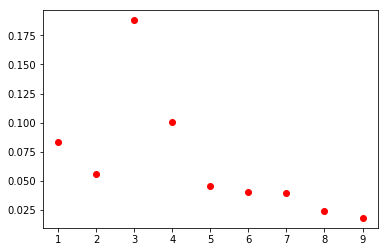

In [34]:
plt.plot(np.array([1,2,3,4,5,6,7,8,9]),
         sig,
         'ro')
plt.show()

### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.